### Integration WP + PS

In [ ]:
import pandas as pd
import numpy as np

t_amb = pd.read_csv('WP_40599_2014.csv')
t_amb.set_index('time', inplace=True)
t_amb.index = pd.to_datetime(t_amb.index)

# Pufferspeicher auswählen 
# Vaillant https://www.vaillant.de/heizung/produkte/pufferspeicher-359745.html#specification
# VPS R 100/1 M - Bereitschaftswärmeverlust Speicher: 0,81 kWh/24h
# VPS R 200/1 B - Bereitschaftswärmeverlust Speicher: 1,4 kWh/24h
# VIH RW 300 - Bereitschaftswärmeverlust Speicher: 1,52 kWh/24
# TWL Pufferspeicher PR 500 Liter - Bereitschaftswärmeverlust Speicher: 1,4 kWh/24h -- https://www.solardirekt24.de/TWL-Pufferspeicher-PR-500-Liter-OEkoLine-A-Isolierung-PR.0500.Iso-A
VPS_100 = 100
VPS_200 = 200
VIH_300 = 300
TWL_PR_500 = 500

V_sp_einfach = 20*9

if V_sp_einfach > VPS_200:
    if V_sp_einfach <= VIH_300:
        V_ps = VIH_300
        PS_verlust = 1.52/24 # kWh/24h
    else:
        V_ps = TWL_PR_500
        PS_verlust = 1.4/24 # kWh/24h
elif V_sp_einfach <= VPS_200:
    if V_sp_einfach <= VPS_100:
        V_ps = VPS_100
        PS_verlust = 0.81/24 # kWh/24h
    else:
        V_ps= VPS_200
        PS_verlust = 1.4/24 # kWh/24h

print('Volumen PS [l]: ', V_ps)


# Wärmegehalt Pufferspeicher
dichte = 1 # kg/m^3
c_wasser = 4.18 # kJ/(kg·K)
T_n_vor = 55
T_n_rueck = 45
Q_ps = round(V_ps*dichte*c_wasser*(T_n_vor - T_n_rueck)/3600, 3)
print('Wärmegehalt PS [kWh]:',  Q_ps) # kWh


# WP und PS Zusammenfügen
t_amb['Wärmegehalt PS'] = np.nan
t_amb['Ladezustand PS'] = np.nan
t_amb['Heizleistung neu'] = np.nan
t_amb['temp_mittel'] = t_amb['temp'].rolling(window=48, min_periods=1).mean()
t_amb['Wärmebedarf_mittel'] = t_amb['Wärmebedarf'].rolling(window=48, min_periods=1).mean()

# Set 1. Reihe 
t_amb.iloc[0, t_amb.columns.get_loc('Wärmegehalt PS')] = Q_ps  
t_amb.iloc[0, t_amb.columns.get_loc('Ladezustand PS')] = 1 
t_amb.iloc[0, t_amb.columns.get_loc('Heizleistung neu')] = t_amb.iloc[0, t_amb.columns.get_loc('Heizleistung')]

for time in t_amb.index[1:]:  # ab der zweiten Zeile
    previous_time = time - pd.Timedelta(hours=1)
    
    # Bedingungsüberprüfung und Debugging
    # print(f"Verarbeite Zeitstempel: {time}, vorheriger Zeitstempel: {previous_time}")
    # print(f"Wärmegehalt PS (vorher): {t_amb.loc[previous_time, 'Wärmegehalt PS']}, Wärmebedarf: {t_amb.loc[time, 'Wärmebedarf']}")
    
    if t_amb.loc[time, 'temp_mittel'] <= 15 and t_amb.loc[time, 'Wärmebedarf_mittel'] >= 1.8:
        if t_amb.loc[time, 'Wärmebedarf'] == 0:
            t_amb.loc[time, 'Heizleistung neu'] = 0
            t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[previous_time, 'Wärmegehalt PS'] - t_amb.loc[time, 'Wärmebedarf'] - PS_verlust
        elif t_amb.loc[time, 'Wärmebedarf'] > t_amb.loc[time, 'Heizleistung']:
            t_amb.loc[time, 'Heizleistung neu'] = t_amb.loc[time, 'Wärmebedarf']
            t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[previous_time, 'Wärmegehalt PS'] - t_amb.loc[time, 'Wärmebedarf'] - PS_verlust + t_amb.loc[time, 'Heizleistung neu']
        elif t_amb.loc[previous_time, 'Wärmegehalt PS'] > t_amb.loc[time, 'Wärmebedarf']:
            # print("Wärmegehalt PS > Wärmebedarf, Heizleistung neu = 0")
            t_amb.loc[time, 'Heizleistung neu'] = 0
            t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[previous_time, 'Wärmegehalt PS'] - t_amb.loc[time, 'Wärmebedarf'] - PS_verlust
        elif t_amb.loc[previous_time, 'Wärmegehalt PS'] < t_amb.loc[time, 'Wärmebedarf']:
            # print("Wärmegehalt PS < Wärmebedarf...")
            if Q_ps - t_amb.loc[previous_time, 'Wärmegehalt PS'] > t_amb.loc[time, 'Heizleistung']:
                # print("Q_ps - Wärmegehalt PS > Heizleistung, Heizleistung neu angepasst")
                t_amb.loc[time, 'Heizleistung neu'] = t_amb.loc[time, 'Heizleistung'] + Q_ps - t_amb.loc[previous_time, 'Wärmegehalt PS']
                t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[previous_time, 'Wärmegehalt PS'] + t_amb.loc[time, 'Heizleistung neu'] - t_amb.loc[time, 'Wärmebedarf'] - PS_verlust
                # print("Heizleistung neu = Heizleistung + Lade PS mehr")
            else:
                # print("Heizleistung neu = Heizleistung")
                t_amb.loc[time, 'Heizleistung neu'] = t_amb.loc[time, 'Heizleistung']
                t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[previous_time, 'Wärmegehalt PS'] + t_amb.loc[time, 'Heizleistung neu'] - t_amb.loc[time, 'Wärmebedarf'] - PS_verlust
    else:
        # print("T_mittel > 15° <- wird nicht geheizt")
        t_amb.loc[time, 'Heizleistung neu'] = 0
        t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[previous_time, 'Wärmegehalt PS'] - PS_verlust 

    # Wärmegehalt darf nicht negativ sein
    if t_amb.loc[time, 'Wärmegehalt PS'] <= 0:
        t_amb.loc[time, 'Wärmegehalt PS'] = 0

    # Berechnung des Ladezustands
    ladezustand = t_amb.loc[time, 'Wärmegehalt PS'] / Q_ps
    if ladezustand > 1:
        # print("Ladezustand > 1, setze Ladezustand auf 1")
        t_amb.loc[time, 'Ladezustand PS'] = 1
    elif ladezustand <= 0:
        # print(f"Ladezustand <= 0, setzte 0")
        t_amb.loc[time, 'Ladezustand PS'] = 0
    else:
        t_amb.loc[time, 'Ladezustand PS'] = ladezustand

t_amb.loc[t_amb['Heizleistung neu'] == 0, 'COP'] = 0
# Filtere die Werte, bei denen Heizleistung neu > 0
cop_filtered = t_amb[t_amb['Heizleistung neu'] > 0]['COP']
cop_mean = cop_filtered.mean()

t_amb['elekt. Leistungaufnahme'] = t_amb['Heizleistung neu']/t_amb['COP']
t_amb['therm. Entnahmelesitung'] = t_amb['Heizleistung'] - t_amb['elekt. Leistungaufnahme']

print('P_el [kW/a]: ', round(t_amb['elekt. Leistungaufnahme'].sum(), 2))
print('Stromkosten WP [€/a]:', round(t_amb['elekt. Leistungaufnahme'].sum()*0.358, 2)) # Strompreis Dezember 24 Bestandkunden €/kWh
print('COP: ', round(cop_mean, 2))

Volumen PS [l]:  200
Wärmegehalt PS [kWh]: 2.322
P_el [kW/a]:  3596.19
Stromkosten WP [€/a]: 1287.44
COP:  3.22


In [89]:
# JAZ
cop_neu = round(t_amb['Wärmebedarf'].sum()/t_amb['elekt. Leistungaufnahme'].sum(), 2)
cop_neu

4.0

In [81]:
t_amb

,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP,Heizleistung,Wärmebedarf,Wärmegehalt PS,Ladezustand PS,Heizleistung neu,temp_mittel,Wärmebedarf_mittel,elekt. Leistungaufnahme,therm. Entnahmelesitung
time,,,,,,,,,,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23,3.434211,0.518056,2.322000,1.000000,3.434211,6.300000,0.518056,1.063223,2.370987
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,0.00,3.947368,0.823876,2.263667,0.974878,0.000000,5.650000,0.670966,NaN,NaN
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,0.00,3.907895,1.116919,2.205333,0.949756,0.000000,5.466667,0.819617,NaN,NaN
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,0.00,3.750000,1.359407,2.147000,0.924634,0.000000,5.475000,0.954565,NaN,NaN
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,0.00,3.671053,1.280667,2.088667,0.899512,0.000000,5.520000,1.019785,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565,2.47,5.171053,4.807082,1.290807,0.555903,5.171053,2.777083,3.760000,2.093544,3.077509
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517,2.40,5.368421,3.853547,2.747348,1.000000,5.368421,2.839583,3.760000,2.236842,3.131579
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792,0.00,5.486842,1.934805,0.754209,0.324810,0.000000,2.891667,3.760000,NaN,NaN


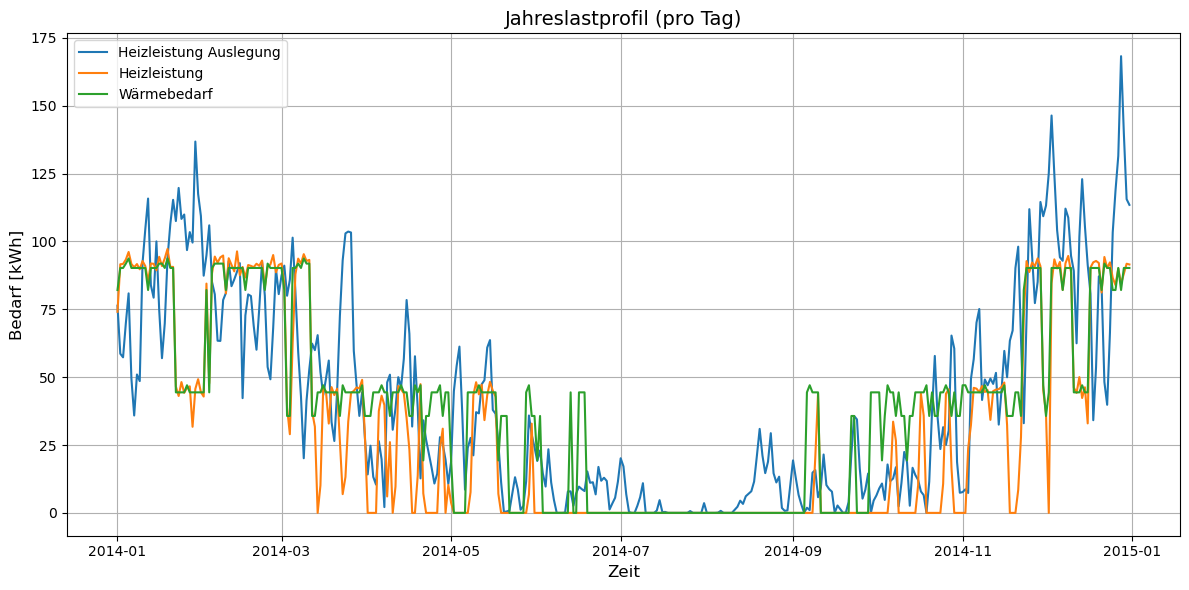

In [66]:
import matplotlib.pyplot as plt
t_amb_d = t_amb.resample('d').sum()

# Plot erstellen
plt.figure(figsize=(12, 6))

# Einzelne Spalten plotten

plt.plot(t_amb_d['Heizleistung'], label='Heizleistung Auslegung')
plt.plot(t_amb_d['Heizleistung neu'], label='Heizleistung')
plt.plot(t_amb_d['Wärmebedarf'], label='Wärmebedarf')
#plt.plot(t_amb_d['Wärmegehalt PS'], label='Wärmegehalt PS')
#plt.plot(t_amb_d['Ladezustand PS'], label='Ladezustand PS')

# Diagramm anpassen
plt.title('Jahreslastprofil (pro Tag)', fontsize=14)
plt.xlabel('Zeit', fontsize=12)
plt.ylabel('Bedarf [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

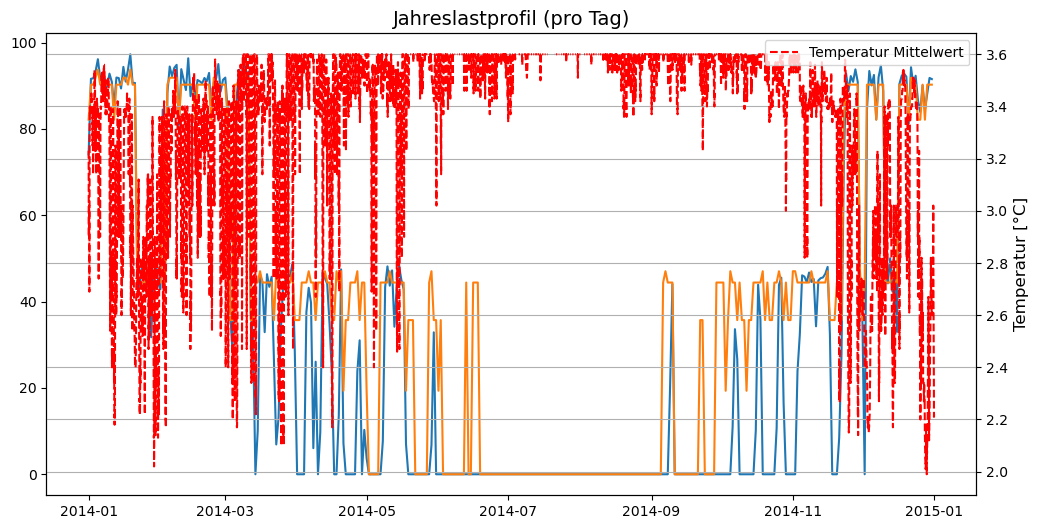

In [79]:
import matplotlib.pyplot as plt

# Resamplet die Daten auf tägliche Summe
t_amb_d = t_amb.resample('d').sum()

# Erstellen Sie eine neue Figur
plt.figure(figsize=(12, 6))

# Plot für die linke y-Achse
# plt.plot(t_amb_d['Heizleistung'], label='Heizleistung Auslegung')
plt.plot(t_amb_d['Heizleistung neu'], label='Heizleistung')
plt.plot(t_amb_d['Wärmebedarf'], label='Wärmebedarf')

# Erstellen der rechten y-Achse
ax2 = plt.gca().twinx()
ax2.plot(t_amb['COP'], label='Temperatur Mittelwert', color='red', linestyle='--')

# Diagramm anpassen
plt.title('Jahreslastprofil (pro Tag)', fontsize=14)
plt.xlabel('Zeit', fontsize=12)
plt.ylabel('Bedarf [kWh]', fontsize=12)
ax2.set_ylabel('Temperatur [°C]', fontsize=12)

# Legende hinzufügen
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Raster anzeigen
plt.grid(True)

# Layout anpassen
# plt.tight_layout()

# Diagramm anzeigen
plt.show()


In [59]:
monthly_stats = t_amb['Wärmebedarf_mittel'].resample('M').agg(['mean', 'min', 'max'])
monthly_stats

C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_11672\2761443820.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = t_amb['Wärmebedarf_mittel'].resample('M').agg(['mean', 'min', 'max'])


,mean,min,max
time,,,
2014-01-31,3.167852,0.518056,4.247915
2014-02-28,3.518036,1.830762,3.891637
2014-03-31,2.417288,1.444830,4.236280
2014-04-30,1.727539,1.114616,2.000930
2014-05-31,1.088029,0.000000,2.000930
2014-06-30,0.370440,0.000000,1.850417
2014-07-31,0.000000,0.000000,0.000000
2014-08-31,0.000000,0.000000,0.000000
2014-09-30,0.473875,0.000000,1.957527


In [73]:
monthly_stats = t_amb['Wärmebedarf'].resample('M').agg(['mean', 'min', 'max'])
monthly_stats

C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_11672\3490310200.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = t_amb['Wärmebedarf'].resample('M').agg(['mean', 'min', 'max'])


,mean,min,max
time,,,
2014-01-31,3.141599,0.0,11.330468
2014-02-28,3.587247,0.0,7.881827
2014-03-31,2.345497,0.0,11.330468
2014-04-30,1.737125,0.0,4.119353
2014-05-31,1.075000,0.0,4.119353
2014-06-30,0.323181,0.0,4.119353
2014-07-31,0.000000,0.0,0.000000
2014-08-31,0.000000,0.0,0.000000
2014-09-30,0.534597,0.0,4.119353
